# Modelagem

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import TimeSeriesSplit

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filtra os pontos se max_fpr for especificado
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    # AUC usando função apropriada
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)

    # Índice do ponto ótimo
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc



def plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=None):
    """
    Plota a curva ROC a partir de fpr, tpr e thresholds já calculados.
    Destaca o melhor threshold.
    """
    optimal_idx = np.where(thresholds == best_threshold)[0][0]

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.3f})', lw=2)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', zorder=5,
                label=f'Melhor Threshold = {best_threshold:.3f}')

    # Linhas auxiliares para melhor visualização
    plt.axhline(y=tpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)
    plt.axvline(x=fpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [85]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Iterações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

#### Leitura dos dados

In [7]:
df = pd.read_csv('./data/Phishing_Legitimate_full.csv')
print(df.shape)
df.head()

(10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [8]:
df = df.drop('id', axis=1)
df = df.rename(columns={'CLASS_LABEL': 'target'})

In [9]:
feature_model = [col for col in df.columns if col not in ['target']]

In [10]:
development, validation = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [72]:
development.to_csv('./data/development_phishing.csv', index=False)
validation.to_csv('./data/validation_phishing.csv', index=False)

In [11]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(4012, 49)

In [12]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [13]:
y_dev.sum()

3988

In [14]:
len(y_dev)

8000

In [15]:
X_no_anomalies = train_no_anomalies[feature_model].values

### Optimization with CMA-ES

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [16]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

In [17]:
def build_iforest(params):
    estimator = IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        random_state=42,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])

def transform_iforest_params(params):
    return {
        'n_estimators': int(params[0]),
        'contamination': float(params[1]),
        'max_samples': float(params[2]),
        'max_features': float(params[3])
    }

def evaluate_model(model, dataset, cv, features):
    roc_auc_scores = []
    for train_index, test_index in cv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = -model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

def objective_iforest(trial, dataset, cv, features):
    n_estimators = trial.suggest_int('n_estimators', 5, 256)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    max_samples = trial.suggest_float('max_samples', 0.3, 1.0)
    max_features = trial.suggest_float('max_features', 0.3, 1.0)
    params = [n_estimators, contamination, max_samples, max_features]

    model_params = transform_iforest_params(params)
    model = build_iforest(model_params)
    mean_score, std_score = evaluate_model(model, dataset, cv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return mean_score - std_score

def optuna_optimization_iforest(dataset, cv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_iforest(trial, dataset, cv, features), n_trials=n_trials)

    return study.best_params, study

In [35]:
import time
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)
start_time = time.time()  # Inicia o cronômetro

best_params_iforest, study_iforest = optuna_optimization_iforest(development, cv, feature_model, n_trials=50)
print(f"Melhores parâmetros para Isolation Forest: {best_params_iforest}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-11-27 16:15:25,014] A new study created in memory with name: no-name-cd82b31b-c52e-42a0-94b3-35c54ea6b2c3
[I 2025-11-27 16:15:26,037] Trial 0 finished with value: 0.7417854682487018 and parameters: {'n_estimators': 35, 'contamination': 0.002891359940488715, 'max_samples': 0.5099698431806241, 'max_features': 0.6380016994109289}. Best is trial 0 with value: 0.7417854682487018.
[I 2025-11-27 16:15:29,234] Trial 1 finished with value: 0.7589775931297963 and parameters: {'n_estimators': 151, 'contamination': 0.003207318904429819, 'max_samples': 0.680394945309378, 'max_features': 0.6796047960990186}. Best is trial 1 with value: 0.7589775931297963.
[I 2025-11-27 16:15:31,233] Trial 2 finished with value: 0.7565080121998945 and parameters: {'n_estimators': 100, 'contamination': 0.0019042331014295453, 'max_samples': 0.6355782883560697, 'max_features': 0.5534838360513823}. Best is trial 1 with value: 0.7589775931297963.
[I 2025-11-27 16:15:33,514] Trial 3 finished with value: 0.762645826

Melhores parâmetros para Isolation Forest: {'n_estimators': 194, 'contamination': 0.0024555111697485213, 'max_samples': 0.9080365662344663, 'max_features': 0.5258110154244413}

--- Resultados Finais ---
Tempo total de execução: 227.08 segundos
Tempo total de execução: 3.78 minutos


In [36]:
data_metrics_iforest = []

for trial in study_iforest.trials:
    data_metrics_iforest.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_iforest = pd.DataFrame(data_metrics_iforest)
df_results_iforest.to_csv('./metrics/results_iforest_cmaes.csv', index=False)
df_results_iforest.head()

,trial,roc_auc_mean,roc_auc_std,value,n_estimators,contamination,max_samples,max_features
0,0,0.752562,0.010776,0.741785,35,0.002891,0.509970,0.638002
1,1,0.769330,0.010353,0.758978,151,0.003207,0.680395,0.679605
2,2,0.768326,0.011818,0.756508,100,0.001904,0.635578,0.553484
3,3,0.770470,0.007824,0.762646,122,0.001821,0.592026,0.885592
4,4,0.771339,0.014213,0.757127,166,0.002580,0.715212,0.673687


In [37]:
df_results_iforest = pd.read_csv('./metrics/results_iforest_cmaes.csv')   

df_results_iforest['roc_auc_adjusted'] = df_results_iforest['roc_auc_mean'] - df_results_iforest['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_iforest.loc[999]
best_params = df_results_iforest.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                39.000000
roc_auc_mean          0.783929
roc_auc_std           0.009706
value                 0.774223
n_estimators        194.000000
contamination         0.002456
max_samples           0.908037
max_features          0.525811
roc_auc_adjusted      0.774223
Name: 39, dtype: float64


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

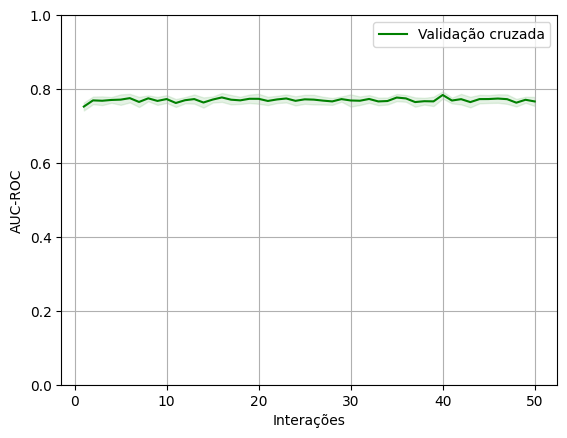

In [39]:
results_df_iforest2 = df_results_iforest[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_iforest2, title="iforest", ylim=(0, 1), train_sizes=np.linspace(1, 50, 50))

In [40]:
n_estimators_best = int(best_params_iforest.get('n_estimators'))
contamination_best = round(float(best_params_iforest.get('contamination')), 5)
max_samples_best = round(float(best_params_iforest.get('max_samples')), 2)
max_features_best = round(float(best_params_iforest.get('max_features')), 2)

print(f"Melhores parâmetros para Isolation Forest: n_estimators={n_estimators_best}, contamination={contamination_best}, max_samples={max_samples_best}, max_features={max_features_best}")

Melhores parâmetros para Isolation Forest: n_estimators=194, contamination=0.00246, max_samples=0.91, max_features=0.53


In [41]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    random_state=42
)

pipe_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['NumDots', 'SubdomainLevel',
                                                 'PathLevel', 'UrlLength',
                                                 'NumDash', 'NumDashInHostname',
                                                 'AtSymbol', 'TildeSymbol',
                                                 'NumUnderscore', 'NumPercent',
                                                 'NumQueryComponents',
                                                 'NumAmpersand', 'NumHash',
                                                 'NumNumericChars', 'NoHttps',
                                                 'RandomString', 'IpAddress',
                                                 'DomainInSubdomains',
                                                 'DomainInPaths',
                                                 'HttpsInHostname',
                                                 'HostnameLength', 'PathLength',
                                                 'QueryLength',
                                                 'DoubleSlashInPath',
                                                 'NumSensitiveWords',
                                                 'EmbeddedBrandName',
                                                 'PctExtHyperlinks',
                                                 'PctExtResourceUrls',
                                                 'ExtFavicon', 'InsecureForms', ...])),
                ('estimator',
                 IsolationForest(contamination=0.00246, max_features=0.53,
                                 max_samples=0.91, n_estimators=194,
                                 random_state=42))])

In [60]:
scores_dev = -pipe_model_iforest.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): -0.1305, AUC: 0.7845
Melhore threshold:  -0.13052452229619133


Classification Report: 
               precision    recall  f1-score   support

           0    0.73772   0.86092   0.79457      4012
           1    0.83183   0.69208   0.75554      3988

    accuracy                        0.77675      8000
   macro avg    0.78477   0.77650   0.77506      8000
weighted avg    0.78463   0.77675   0.77512      8000

Specificity: 0.8609172482552343
Gini:  0.5689128702158319
ROC AUC::  0.784456435107916


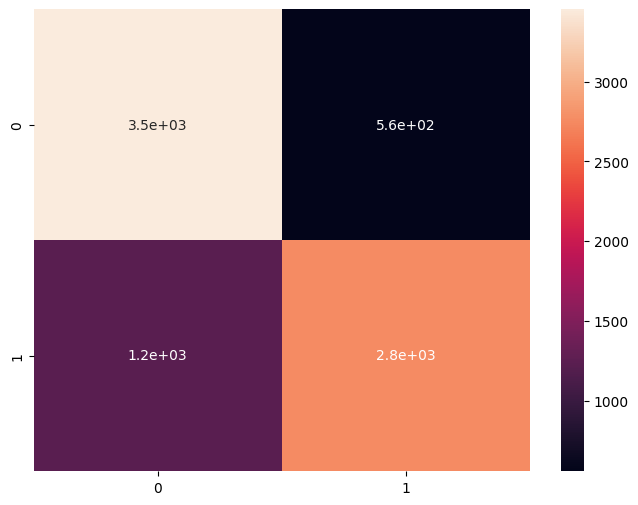

In [61]:
metrics(y_dev, y_pred, scores_dev)

In [54]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [ ]:
scores_valid = -pipe_model_iforest.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

Classification Report: 
               precision    recall  f1-score   support

           0    0.73021   0.86842   0.79334       988
           1    0.84242   0.68676   0.75667      1012

    accuracy                        0.77650      2000
   macro avg    0.78632   0.77759   0.77501      2000
weighted avg    0.78699   0.77650   0.77479      2000

Specificity: 0.868421052631579
Gini:  0.5559960634331342
ROC AUC::  0.7779980317165671


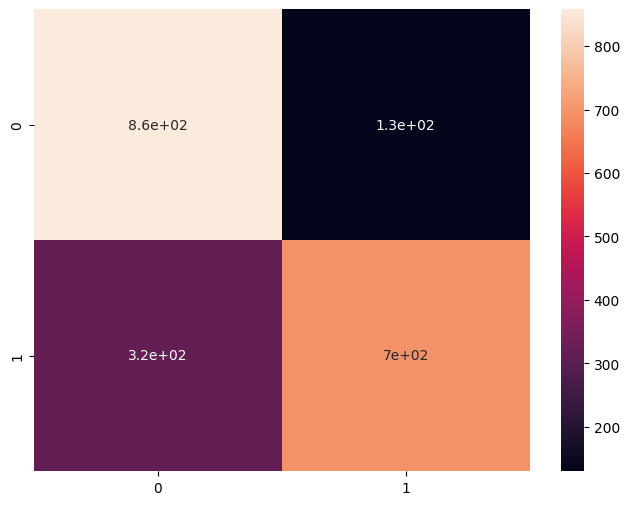

In [59]:
metrics(y_valid, y_pred, scores_valid)

In [ ]:
validation['scores_iforest']=-pipe_model_iforest.decision_function(X_valid)

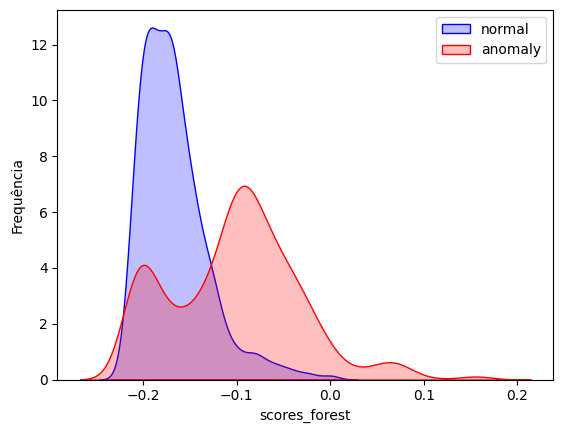

In [ ]:
g = sns.kdeplot(validation["scores_iforest"][(validation["target"] == 0) & (validation["scores_iforest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_iforest"][(validation["target"] == 1) & (validation["scores_iforest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_iforest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [50]:
with open('./models/pipeline_iForest_cmaes.pkl', 'wb') as file: 
    pickle.dump(pipe_model_iforest, file)

### EllipticEnvelope

https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope

In [75]:
from sklearn.covariance import EllipticEnvelope

In [79]:
def build_elliptic(params):
    model = EllipticEnvelope(
        contamination=float(params['contamination']),
        support_fraction=params['support_fraction'],
        store_precision=True,
        assume_centered=False,
        random_state=42
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_elliptic_params(params):
    return {
        'contamination': float(params[0]),
        'support_fraction': float(params[1])
    }

def objective_elliptic(trial, dataset, cv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    support_fraction = trial.suggest_float('support_fraction', 0.1, 1.0)

    params = [contamination, support_fraction]
    model_params = transform_elliptic_params(params)
    model = build_elliptic(model_params)

    mean_score, std_score = evaluate_model(model, dataset, cv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return mean_score - std_score


def evaluate_model(model, dataset, cv, features):
    roc_auc_scores = []
    for train_index, test_index in cv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = -model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score


def optuna_optimization_elliptic(dataset, cv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_elliptic(trial, dataset, cv, features), n_trials=n_trials)

    return study.best_params, study

In [80]:
import time
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)
start_time = time.time()  # Inicia o cronômetro

best_params_elliptic, study_elliptic = optuna_optimization_elliptic(development, cv, feature_model, n_trials=50)
print(f"Melhores parâmetros para Isolation Forest: {best_params_elliptic}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-11-30 12:30:01,457] A new study created in memory with name: no-name-03af7f09-9bab-4d86-a282-1624e4673d4b
[I 2025-11-30 12:30:08,461] Trial 0 finished with value: 0.7265427394078017 and parameters: {'contamination': 0.0011597060903190137, 'support_fraction': 0.7743559814842377}. Best is trial 0 with value: 0.7265427394078017.
[I 2025-11-30 12:30:17,159] Trial 1 finished with value: 0.7015714657694587 and parameters: {'contamination': 0.0019854119893419537, 'support_fraction': 0.5630517441655618}. Best is trial 0 with value: 0.7265427394078017.
[I 2025-11-30 12:30:23,748] Trial 2 finished with value: 0.7042737405846725 and parameters: {'contamination': 0.0022638636367094483, 'support_fraction': 0.5313459488068707}. Best is trial 0 with value: 0.7265427394078017.
[I 2025-11-30 12:30:31,826] Trial 3 finished with value: 0.7095047998339384 and parameters: {'contamination': 0.0031827735588656992, 'support_fraction': 0.33068601532170006}. Best is trial 0 with value: 0.726542739407801

Melhores parâmetros para Isolation Forest: {'contamination': 0.0011597060903190137, 'support_fraction': 0.7743559814842377}

--- Resultados Finais ---
Tempo total de execução: 348.41 segundos
Tempo total de execução: 5.81 minutos


In [81]:
data_metrics_elliptic = []

for trial in study_elliptic.trials:
    data_metrics_elliptic.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_elliptic = pd.DataFrame(data_metrics_elliptic)
df_results_elliptic.to_csv('./metrics/results_elliptic_cmaes.csv', index=False)
df_results_elliptic.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,support_fraction
0,0,0.730446,0.003903,0.726543,0.001160,0.774356
1,1,0.712139,0.010568,0.701571,0.001985,0.563052
2,2,0.724667,0.020393,0.704274,0.002264,0.531346
3,3,0.740641,0.031137,0.709505,0.003183,0.330686
4,4,0.712551,0.010775,0.701776,0.002578,0.561982


In [82]:
df_results_elliptic = pd.read_csv('./metrics/results_elliptic_cmaes.csv')   

df_results_elliptic['roc_auc_adjusted'] = df_results_elliptic['roc_auc_mean'] - df_results_elliptic['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_elliptic['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_elliptic.loc[999]
best_params = df_results_elliptic.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               0.000000
roc_auc_mean        0.730446
roc_auc_std         0.003903
value               0.726543
contamination       0.001160
support_fraction    0.774356
roc_auc_adjusted    0.726543
Name: 0, dtype: float64


In [83]:
contamination_best = best_params['contamination']
support_fraction_best = best_params['support_fraction']

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

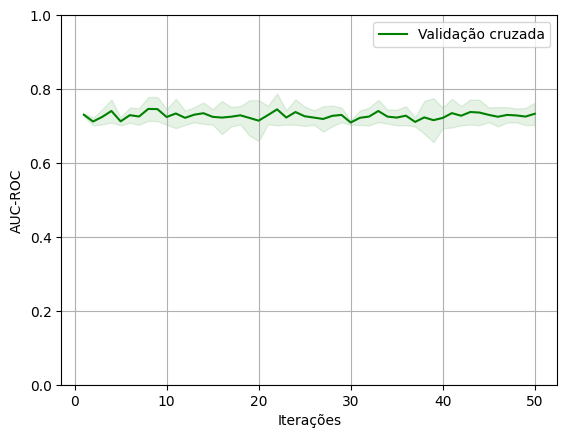

In [86]:
results_df_elliptic2 = df_results_elliptic[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_elliptic2, title="elli", ylim=(0, 1), train_sizes=np.linspace(1, 50, 50))

In [87]:
estimator  = EllipticEnvelope(
        contamination=float(contamination_best),
        support_fraction=float(support_fraction_best),
        store_precision=True,
        assume_centered=False,
        random_state=42
    )

pipe_model_elliptic = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_elliptic.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['NumDots', 'SubdomainLevel',
                                                 'PathLevel', 'UrlLength',
                                                 'NumDash', 'NumDashInHostname',
                                                 'AtSymbol', 'TildeSymbol',
                                                 'NumUnderscore', 'NumPercent',
                                                 'NumQueryComponents',
                                                 'NumAmpersand', 'NumHash',
                                                 'NumNumericChars', 'NoHttps',
                                                 'RandomString', 'IpAddress',
                                                 'DomainInSubdomains',
                                                 'DomainInPaths',
                                                 'HttpsInHostname',
                                                 'HostnameLength', 'PathLength',
                                                 'QueryLength',
                                                 'DoubleSlashInPath',
                                                 'NumSensitiveWords',
                                                 'EmbeddedBrandName',
                                                 'PctExtHyperlinks',
                                                 'PctExtResourceUrls',
                                                 'ExtFavicon', 'InsecureForms', ...])),
                ('estimator',
                 EllipticEnvelope(contamination=0.001159706090319,
                                  random_state=42,
                                  support_fraction=0.7743559814842377))])

Melhor Threshold (FPR ≤ 1): -12702.0761, AUC: 0.7686
Melhore threshold:  -12702.07608597466
Classification Report: 
               precision    recall  f1-score   support

           0    0.73131   0.82428   0.77502      4012
           1    0.79730   0.69534   0.74283      3988

    accuracy                        0.76000      8000
   macro avg    0.76431   0.75981   0.75893      8000
weighted avg    0.76421   0.76000   0.75897      8000

Specificity: 0.8242771684945165
Gini:  0.5372374601371412
ROC AUC::  0.7686187300685706


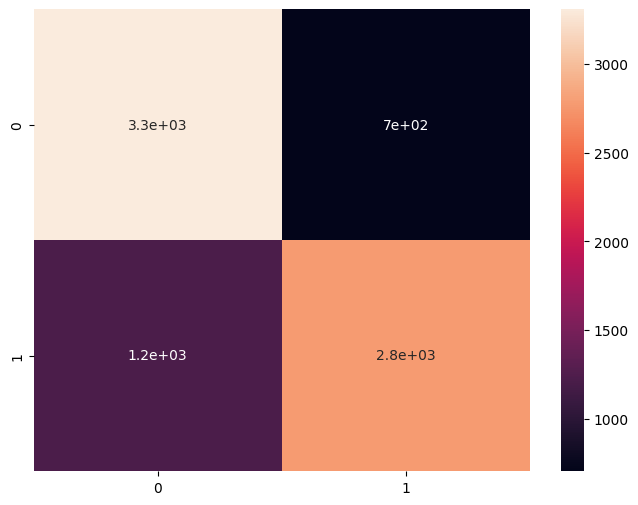

In [88]:
scores_dev = -pipe_model_elliptic.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

metrics(y_dev, y_pred, scores_dev)

Classification Report: 
               precision    recall  f1-score   support

           0    0.72801   0.81275   0.76805       988
           1    0.79376   0.70356   0.74594      1012

    accuracy                        0.75750      2000
   macro avg    0.76089   0.75816   0.75700      2000
weighted avg    0.76128   0.75750   0.75686      2000

Specificity: 0.812753036437247
Gini:  0.5290301803459698
ROC AUC::  0.7645150901729849


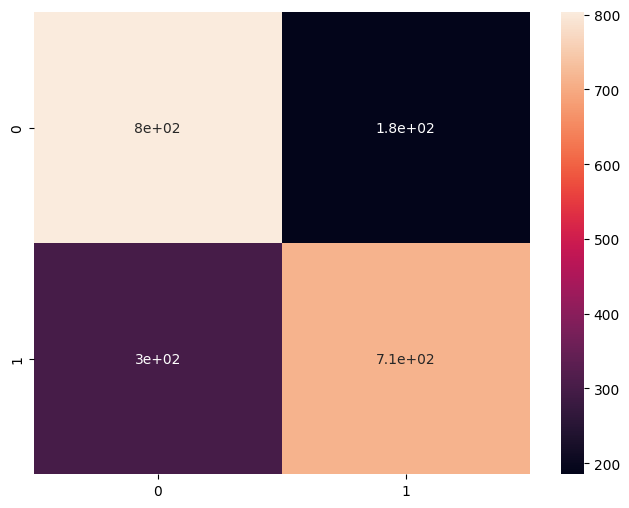

In [89]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

scores_valid = -pipe_model_elliptic.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

metrics(y_valid, y_pred, scores_valid)

In [90]:
validation['scores_elliptic']=-pipe_model_elliptic.decision_function(X_valid)   

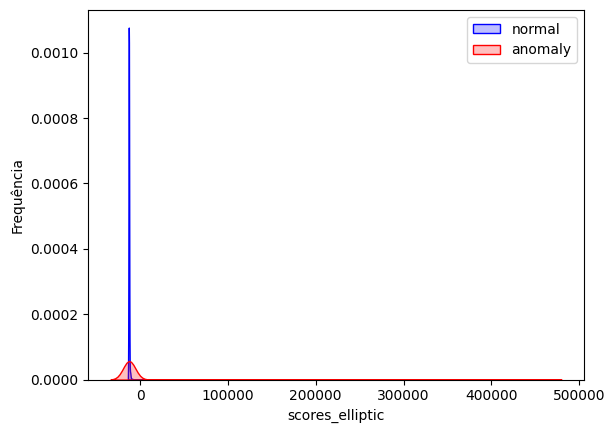

In [91]:
g = sns.kdeplot(validation["scores_elliptic"][(validation["target"] == 0) & (validation["scores_elliptic"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_elliptic"][(validation["target"] == 1) & (validation["scores_elliptic"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_elliptic")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [92]:
with open('./models/pipeline_elliptic_cmaes.pkl', 'wb') as file: 
    pickle.dump(pipe_model_elliptic, file)

## Pyod

### Empirical Cumulative Distribution Functions (ECOD)

In [22]:
from pyod.models.ecod import ECOD

In [27]:
def evaluate_model_pyod(model, dataset, cv, features):
    roc_auc_scores = []
    for train_index, test_index in cv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

def build_ecod(params):
    model = ECOD(
        contamination=float(params['contamination'])
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_ecod_params(params):
    return {
        'contamination': float(params[0])
    }

def objective_ecod(trial, dataset, cv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.05)
    params = [contamination]
    model_params = transform_ecod_params(params)
    model = build_ecod(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, cv, features)
    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return mean_score - std_score

def optuna_optimization_ecod(dataset, cv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_ecod(trial, dataset, cv, features), n_trials=n_trials)

    return study.best_params, study


In [28]:
import time
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)
start_time = time.time()  # Inicia o cronômetro

best_params_ecod, study_ecod = optuna_optimization_ecod(development, cv, feature_model, n_trials=50)
print(f"Melhores parâmetros para SO_GAAL: {best_params_ecod}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-11-30 01:58:17,750] A new study created in memory with name: no-name-9f3d0b4f-3366-4356-816d-636a8ad1d1f6
[I 2025-11-30 01:58:18,527] Trial 0 finished with value: 0.6325601229889569 and parameters: {'contamination': 0.006846920704904756}. Best is trial 0 with value: 0.6325601229889569.
[W 2025-11-30 01:58:18,528] `CmaEsSampler` only supports two or more dimensional continuous search space. `RandomSampler` is used instead of `CmaEsSampler`.
[I 2025-11-30 01:58:19,159] Trial 1 finished with value: 0.6325601229889569 and parameters: {'contamination': 0.00946355837582474}. Best is trial 0 with value: 0.6325601229889569.
[I 2025-11-30 01:58:19,851] Trial 2 finished with value: 0.6325601229889569 and parameters: {'contamination': 0.042972638445232005}. Best is trial 0 with value: 0.6325601229889569.
[I 2025-11-30 01:58:20,451] Trial 3 finished with value: 0.6325601229889569 and parameters: {'contamination': 0.011087332296420619}. Best is trial 0 with value: 0.6325601229889569.
[I 202

Melhores parâmetros para SO_GAAL: {'contamination': 0.006846920704904756}

--- Resultados Finais ---
Tempo total de execução: 32.18 segundos
Tempo total de execução: 0.54 minutos


In [29]:
data_metrics_ecod = []

for trial in study_ecod.trials:
    data_metrics_ecod.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_ecod = pd.DataFrame(data_metrics_ecod)
df_results_ecod.to_csv('./metrics/results_ecod_cmaes.csv', index=False)
df_results_ecod.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination
0,0,0.641637,0.009077,0.63256,0.006847
1,1,0.641637,0.009077,0.63256,0.009464
2,2,0.641637,0.009077,0.63256,0.042973
3,3,0.641637,0.009077,0.63256,0.011087
4,4,0.641637,0.009077,0.63256,0.008725


In [30]:
df_results_ecod = pd.read_csv('./metrics/results_ecod_cmaes.csv')   

df_results_ecod['roc_auc_adjusted'] = df_results_ecod['roc_auc_mean'] - df_results_ecod['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_ecod['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_ecod.loc[999]
best_params = df_results_ecod.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               0.000000
roc_auc_mean        0.641637
roc_auc_std         0.009077
value               0.632560
contamination       0.006847
roc_auc_adjusted    0.632560
Name: 0, dtype: float64


In [33]:
contamination_best = best_params['contamination']

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

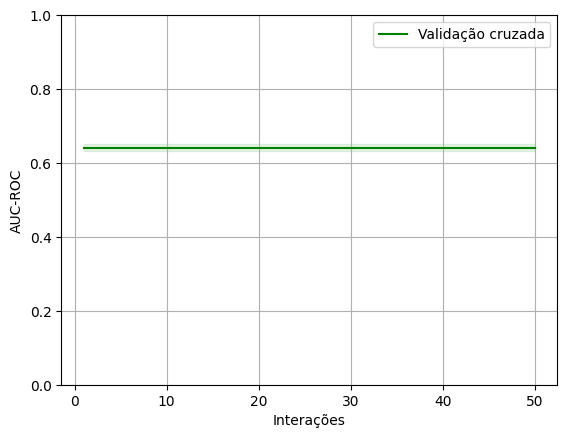

In [31]:
results_df_ecod2 = df_results_ecod[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_ecod2, title="ecod", ylim=(0, 1), train_sizes=np.linspace(1, 50, 50))

In [34]:
estimator = ECOD(
    contamination=contamination_best
)

pipe_model_ecod = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_ecod.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['NumDots', 'SubdomainLevel',
                                                 'PathLevel', 'UrlLength',
                                                 'NumDash', 'NumDashInHostname',
                                                 'AtSymbol', 'TildeSymbol',
                                                 'NumUnderscore', 'NumPercent',
                                                 'NumQueryComponents',
                                                 'NumAmpersand', 'NumHash',
                                                 'NumNumericChars', 'NoHttps',
                                                 'RandomString', 'IpAddress',
                                                 'DomainInSubdomains',
                                                 'DomainInPaths',
                                                 'HttpsInHostname',
                                                 'HostnameLength', 'PathLength',
                                                 'QueryLength',
                                                 'DoubleSlashInPath',
                                                 'NumSensitiveWords',
                                                 'EmbeddedBrandName',
                                                 'PctExtHyperlinks',
                                                 'PctExtResourceUrls',
                                                 'ExtFavicon', 'InsecureForms', ...])),
                ('estimator',
                 ECOD(contamination=0.0068469207049047, n_jobs=1))])

In [35]:
scores_dev = pipe_model_ecod.decision_function(X_dev)

In [36]:
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 24.6219, AUC: 0.5456
Melhore threshold:  24.621938439466412


Classification Report: 
               precision    recall  f1-score   support

           0    0.54337   0.43096   0.48068      4012
           1    0.52615   0.63566   0.57574      3988

    accuracy                        0.53300      8000
   macro avg    0.53476   0.53331   0.52821      8000
weighted avg    0.53479   0.53300   0.52807      8000

Specificity: 0.4309571286141575
Gini:  0.09122719604476437
ROC AUC::  0.5456135980223822


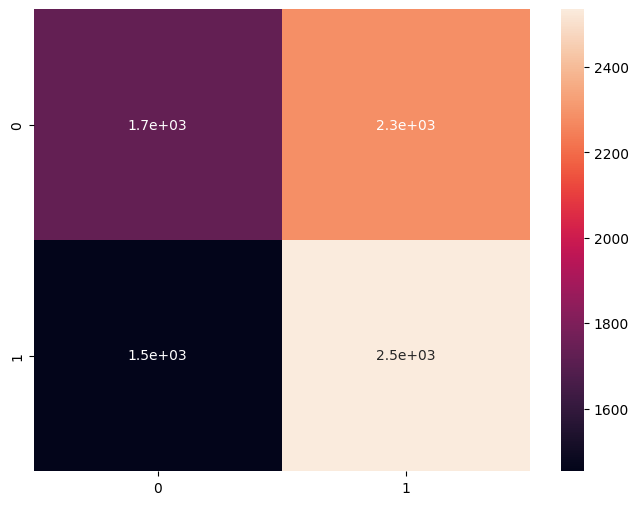

In [37]:
metrics(y_dev, y_pred, scores_dev)

In [38]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [39]:
scores_valid = pipe_model_ecod.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

Classification Report: 
               precision    recall  f1-score   support

           0    0.61094   0.39575   0.48034       988
           1    0.56103   0.75395   0.64334      1012

    accuracy                        0.57700      2000
   macro avg    0.58598   0.57485   0.56184      2000
weighted avg    0.58568   0.57700   0.56282      2000

Specificity: 0.395748987854251
Gini:  0.25570882207037826
ROC AUC::  0.6278544110351891


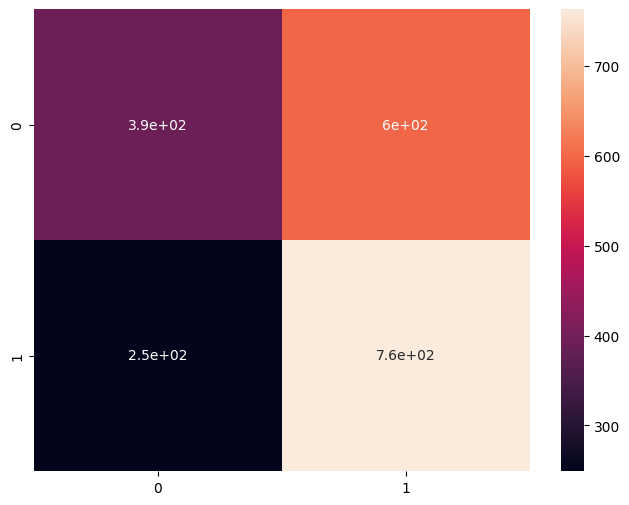

In [40]:
metrics(y_valid, y_pred, scores_valid)


In [41]:
validation['scores_ecod']=-pipe_model_ecod.decision_function(X_valid)

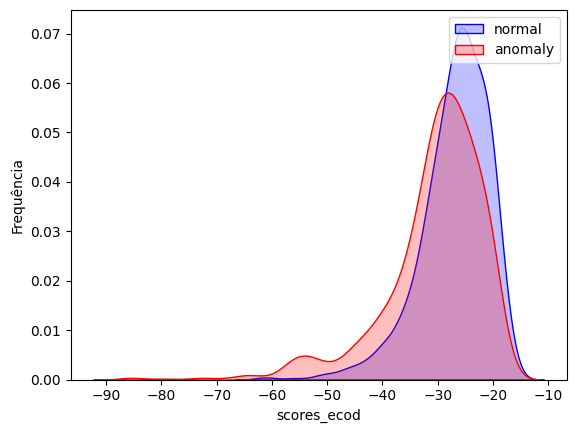

In [42]:
g = sns.kdeplot(validation["scores_ecod"][(validation["target"] == 0) & (validation["scores_ecod"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_ecod"][(validation["target"] == 1) & (validation["scores_ecod"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_ecod")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [43]:
with open('./models/pipeline_ecod_cmaes.pkl', 'wb') as file: 
    pickle.dump(pipe_model_ecod, file)

### Copula Based Outlier Detector (COPOD)

In [46]:
from pyod.models.copod import COPOD

In [49]:
def evaluate_model_pyod(model, dataset, cv, features):
    roc_auc_scores = []
    for train_index, test_index in cv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

def build_copod(params):
    model = COPOD(
        contamination=float(params['contamination'])
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_copod_params(params):
    return {
        'contamination': float(params[0])
    }

def objective_copod(trial, dataset, cv, features):
    contamination = trial.suggest_float('contamination', 0.001, 0.2)

    params = [contamination]
    model_params = transform_copod_params(params)
    model = build_copod(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, cv, features)
    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return mean_score - std_score


def optuna_optimization_copod(dataset, cv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_copod(trial, dataset, cv, features), n_trials=n_trials)

    return study.best_params, study

In [50]:
import time
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)
start_time = time.time()  # Inicia o cronômetro

best_params_copod, study_copod = optuna_optimization_copod(development, cv, feature_model, n_trials=50)
print(f"Melhores parâmetros para COPOD: {best_params_copod}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-11-30 02:24:17,064] A new study created in memory with name: no-name-f71918f0-82fc-4774-93bb-b7cb28de6556
[I 2025-11-30 02:24:17,902] Trial 0 finished with value: 0.5855953883345356 and parameters: {'contamination': 0.08055008971708698}. Best is trial 0 with value: 0.5855953883345356.
[W 2025-11-30 02:24:17,903] `CmaEsSampler` only supports two or more dimensional continuous search space. `RandomSampler` is used instead of `CmaEsSampler`.
[I 2025-11-30 02:24:18,787] Trial 1 finished with value: 0.5855953883345356 and parameters: {'contamination': 0.19190706135155092}. Best is trial 0 with value: 0.5855953883345356.
[I 2025-11-30 02:24:19,409] Trial 2 finished with value: 0.5855953883345356 and parameters: {'contamination': 0.15448476075761206}. Best is trial 0 with value: 0.5855953883345356.
[I 2025-11-30 02:24:20,034] Trial 3 finished with value: 0.5855953883345356 and parameters: {'contamination': 0.08699421459094547}. Best is trial 0 with value: 0.5855953883345356.
[I 2025-1

Melhores parâmetros para COPOD: {'contamination': 0.08055008971708698}

--- Resultados Finais ---
Tempo total de execução: 35.70 segundos
Tempo total de execução: 0.59 minutos


In [52]:
data_metrics_copod = []

for trial in study_copod.trials:
    data_metrics_copod.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_copod = pd.DataFrame(data_metrics_copod)
df_results_copod.to_csv('./metrics/results_copod_cmaes.csv', index=False)
df_results_copod.head()

df_results_copod = pd.read_csv('./metrics/results_copod_cmaes.csv') 

In [53]:
df_results_copod['roc_auc_adjusted'] = df_results_copod['roc_auc_mean'] - df_results_copod['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_copod['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_copod.loc[999]
best_params = df_results_copod.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               0.000000
roc_auc_mean        0.596123
roc_auc_std         0.010528
value               0.585595
contamination       0.080550
roc_auc_adjusted    0.585595
Name: 0, dtype: float64


In [54]:
contamination_best = best_params['contamination']

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

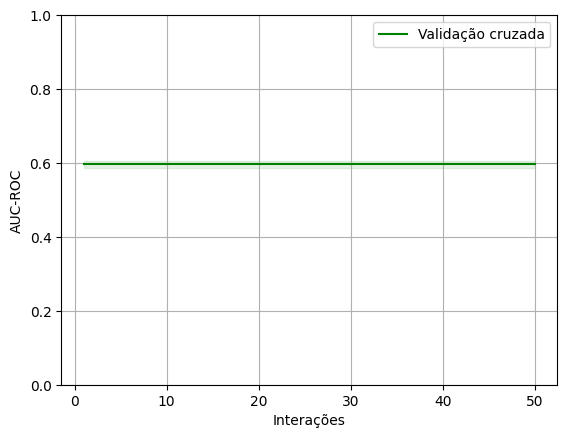

In [55]:
results_df_copod2 = df_results_copod[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_copod2, title="copod", ylim=(0, 1), train_sizes=np.linspace(1, 50, 50))

In [56]:
estimator  = COPOD(
    contamination=contamination_best
)

pipe_model_copod = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_copod.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['NumDots', 'SubdomainLevel',
                                                 'PathLevel', 'UrlLength',
                                                 'NumDash', 'NumDashInHostname',
                                                 'AtSymbol', 'TildeSymbol',
                                                 'NumUnderscore', 'NumPercent',
                                                 'NumQueryComponents',
                                                 'NumAmpersand', 'NumHash',
                                                 'NumNumericChars', 'NoHttps',
                                                 'RandomString', 'IpAddress',
                                                 'DomainInSubdomains',
                                                 'DomainInPaths',
                                                 'HttpsInHostname',
                                                 'HostnameLength', 'PathLength',
                                                 'QueryLength',
                                                 'DoubleSlashInPath',
                                                 'NumSensitiveWords',
                                                 'EmbeddedBrandName',
                                                 'PctExtHyperlinks',
                                                 'PctExtResourceUrls',
                                                 'ExtFavicon', 'InsecureForms', ...])),
                ('estimator',
                 COPOD(contamination=0.0805500897170869, n_jobs=1))])

In [57]:
scores_dev = pipe_model_copod.decision_function(X_dev)

In [58]:
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 27.2353, AUC: 0.5202
Melhore threshold:  27.235333612994463


Classification Report: 
               precision    recall  f1-score   support

           0    0.52472   0.82802   0.64237      4012
           1    0.58658   0.24549   0.34612      3988

    accuracy                        0.53763      8000
   macro avg    0.55565   0.53675   0.49424      8000
weighted avg    0.55556   0.53763   0.49469      8000

Specificity: 0.8280159521435693
Gini:  0.04048686438177951
ROC AUC::  0.5202434321908898


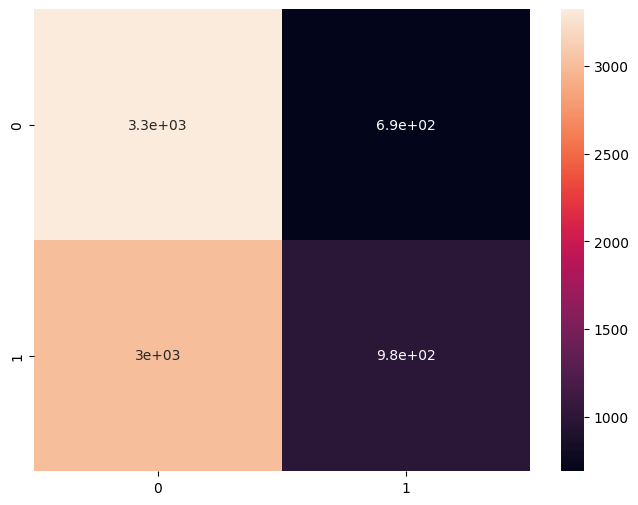

In [59]:

metrics(y_dev, y_pred, scores_dev)

In [60]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [ ]:
scores_valid = pipe_model_copod.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

Classification Report: 
               precision    recall  f1-score   support

           0    0.53938   0.82490   0.65226       988
           1    0.64622   0.31225   0.42105      1012

    accuracy                        0.56550      2000
   macro avg    0.59280   0.56858   0.53666      2000
weighted avg    0.59344   0.56550   0.53527      2000

Specificity: 0.8248987854251012
Gini:  0.16767014450080797
ROC AUC::  0.583835072250404


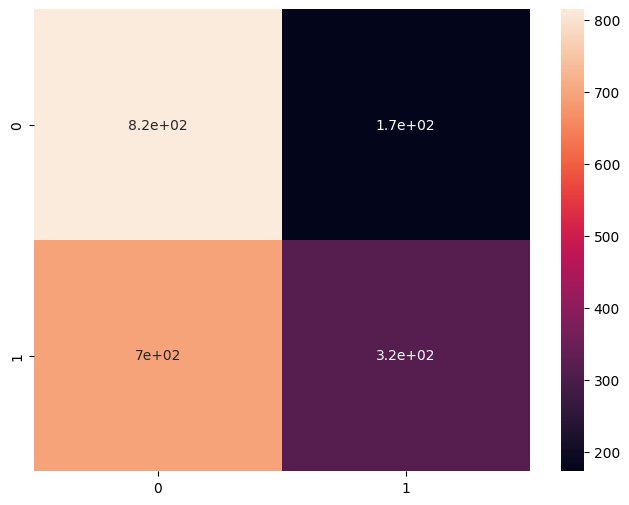

In [63]:
metrics(y_valid, y_pred, scores_valid)

In [65]:
validation['scores_copod']=pipe_model_copod.decision_function(X_valid)

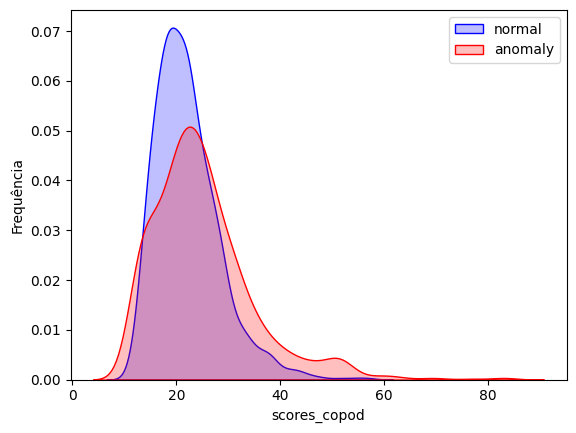

In [66]:
g = sns.kdeplot(validation["scores_copod"][(validation["target"] == 0) & (validation["scores_copod"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_copod"][(validation["target"] == 1) & (validation["scores_copod"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_copod")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [67]:
with open('./models/pipeline_copod_cmaes.pkl', 'wb') as file: 
    pickle.dump(pipe_model_copod, file)

### Deep Isolation Forest

In [73]:
from pyod.models.dif import DIF
import torch


def build_dif(params):
    """
    Constrói o Deep Isolation Forest (DIF) do PyOD
    dentro de um Pipeline com StandardScaler.
    """
    estimator = DIF(
        batch_size=int(params['batch_size']),
        representation_dim=int(params['representation_dim']),
        hidden_neurons=params['hidden_neurons'],       # list, tuple, or None
        hidden_activation=params['hidden_activation'], # 'tanh', 'relu', etc.
        skip_connection=bool(params['skip_connection']),
        n_ensemble=int(params['n_ensemble']),
        n_estimators=int(params['n_estimators']),
        max_samples=int(params['max_samples']),
        contamination=float(params['contamination']),
        random_state=42,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])




def transform_dif_params(params):
    return {
        'batch_size': int(params[0]),
        'representation_dim': int(params[1]),
        'hidden_neurons': params[2],          # mantém lista/None
        'hidden_activation': params[3],
        'skip_connection': bool(params[4]),
        'n_ensemble': int(params[5]),
        'n_estimators': int(params[6]),
        'max_samples': int(params[7]),
        'contamination': float(params[8])
    }



def evaluate_model_pyod(model, dataset, cv, features):
    roc_auc_scores = []

    for train_index, test_index in cv.split(dataset):
        train_data = dataset.iloc[train_index]

        # Treina só com normais (target = 0)
        X_train = train_data[train_data['target'] == 0][features]

        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)

        y_scores = model['estimator'].decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    return np.mean(roc_auc_scores), np.std(roc_auc_scores)


def objective_dif(trial, dataset, cv, features):
    batch_size = trial.suggest_int('batch_size', 64, 1000)
    representation_dim = trial.suggest_int('representation_dim', 4, 64)

    # hidden_neurons é uma lista; Optuna seleciona tamanho e base
    hidden_neurons = trial.suggest_categorical(
        'hidden_neurons',
        [
            None,
            [32, 16],
            [64, 32]
        ]
    )

    hidden_activation = trial.suggest_categorical(
        'hidden_activation',
        ['tanh', 'relu']
    )

    skip_connection = trial.suggest_categorical('skip_connection', [False, True])

    n_ensemble = trial.suggest_int('n_ensemble', 10, 100)
    n_estimators = trial.suggest_int('n_estimators', 5, 256)

    max_samples = trial.suggest_int('max_samples', 32, 256)

    contamination = trial.suggest_float('contamination', 0.0001, 0.005)

    params = [
        batch_size,
        representation_dim,
        hidden_neurons,
        hidden_activation,
        skip_connection,
        n_ensemble,
        n_estimators,
        max_samples,
        contamination
    ]

    model_params = transform_dif_params(params)
    model = build_dif(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, cv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return mean_score - std_score


def optuna_optimization_dif(dataset, cv, features, n_trials=50):
    sampler = optuna.samplers.CmaEsSampler()

    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(lambda trial: objective_dif(trial, dataset, cv, features),
                   n_trials=n_trials)

    return study.best_params, study


In [74]:
import time
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)
start_time = time.time()  # Inicia o cronômetro

best_params_dif, study_dif = optuna_optimization_dif(development, cv, feature_model, n_trials=50)
print(f"Melhores parâmetros para Isolation Forest: {best_params_dif}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-11-30 02:57:49,439] A new study created in memory with name: no-name-7361fbd6-971d-41cb-aaf3-d826b2124d5a
[I 2025-11-30 03:01:40,559] Trial 0 finished with value: 0.4080217005758267 and parameters: {'batch_size': 668, 'representation_dim': 10, 'hidden_neurons': [32, 16], 'hidden_activation': 'relu', 'skip_connection': False, 'n_ensemble': 24, 'n_estimators': 85, 'max_samples': 59, 'contamination': 0.003943739869746558}. Best is trial 0 with value: 0.4080217005758267.
[W 2025-11-30 03:01:40,578] The parameter 'hidden_neurons' in trial#1 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-11-30 03:01:40,580] The parameter 'hidden_activation' in trial#1 is sa

KeyboardInterrupt: 

In [70]:
data_metrics_dif = []

for trial in study_dif.trials:
    data_metrics_dif.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_dif = pd.DataFrame(data_metrics_dif)
df_results_dif.to_csv('./metrics/results_dif_cmaes.csv', index=False)
df_results_dif.head()

,trial,roc_auc_mean,roc_auc_std,value,batch_size,representation_dim,hidden_neurons,hidden_activation,skip_connection,n_ensemble,n_estimators,max_samples,contamination
0,0,0.400065,0.003618,0.396447,577,21,"[32, 16]",tanh,False,81,1,410,0.001048
1,1,0.394838,0.014389,0.380449,847,24,None,tanh,True,43,9,323,0.004894
2,2,0.378838,0.019812,0.359026,460,27,[32],tanh,False,40,6,64,0.004549
3,3,0.387393,0.020778,0.366615,1680,14,[64],tanh,False,30,10,166,0.002654
4,4,0.430080,0.013608,0.416472,1556,33,None,relu,False,29,8,374,0.007579


In [71]:
df_results_dif = pd.read_csv('./metrics/results_dif_cmaes.csv')   

df_results_dif['roc_auc_adjusted'] = df_results_dif['roc_auc_mean'] - df_results_dif['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_dif['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_dif.loc[999]
best_params = df_results_dif.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                       26
roc_auc_mean          0.430652
roc_auc_std           0.011314
value                 0.419338
batch_size                1347
representation_dim           9
hidden_neurons             NaN
hidden_activation         relu
skip_connection           True
n_ensemble                  31
n_estimators                 8
max_samples                245
contamination         0.007164
roc_auc_adjusted      0.419338
Name: 26, dtype: object
